In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np

## Calculate overlap

In [3]:
from scripts.interneuron_placement import Pickle

from scripts.spatial_layout import get_overlap

In [4]:
e1 = Pickle(25, 50, 40, 20, 0.0)
e2 = Pickle(75, 50, 40, 20, np.pi/2.0)


(0, 100)

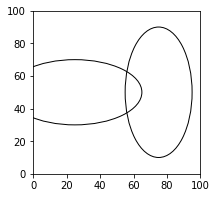

In [5]:
fig, ax = plt.subplots(1,1, figsize=(3,3))

ax.add_artist(e1.get_ellipse())
ax.add_artist(e2.get_ellipse())
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)


In [6]:
e1.get_area()

2513.2741228718346

In [7]:
get_overlap(e1, e1, ds = 1)

2497

In [8]:
get_overlap(e1, e2, ds=1)

165

## Optimize layout

Normalized approach:
* entropy for N orientations bins is maximally ln(N)
* expected overlap NA*axonal_area - sheet_area

In [9]:
from scripts.interneuron_placement import plot_neural_sheet

In [10]:
from scripts.spatial_network.run_entropy_maximisation_orientation_map import get_orientation_map

In [11]:
from scipy.optimize import differential_evolution

In [12]:
import scripts.spatial_layout 

In [13]:
correlation_length = 200.0
map_seed = 1
sheet_size = 450
NE = 30**2
NI = 10**2
long_axis = 100
short_axis = 25
number_of_bins = 10
ds = sheet_size/int(np.sqrt(NE))

orientation_map = get_orientation_map(correlation_length, map_seed, sheet_size, NE, data_folder = "../data/")

In [14]:
spatial_layout = scripts.spatial_layout.SpatialLayout(orientation_map, NE, NI, long_axis, short_axis, sheet_size)

In [9]:
from scripts.interneuron_placement import plot_neural_sheet

from scripts.spatial_network.run_entropy_maximisation_orientation_map import get_orientation_map

from scipy.optimize import differential_evolution

import scripts.spatial_layout 

correlation_length = 200.0
map_seed = 1
sheet_size = 450
NE = 30**2
NI = 10**2
long_axis = 100
short_axis = 25
number_of_bins = 10
ds = sheet_size/int(np.sqrt(NE))

orientation_map = get_orientation_map(correlation_length, map_seed, sheet_size, NE, data_folder = "../data/")

spatial_layout = scripts.spatial_layout.SpatialLayout(orientation_map, NE, NI, long_axis, short_axis, sheet_size)

In [15]:
ex_positions = spatial_layout.ex_positions
ex_tunings = spatial_layout.ex_tunings

#### Test random orientation

In [16]:
random_orientation = np.random.uniform(-np.pi, np.pi, size=NI)

In [17]:
%%timeit
random_orientation = np.random.uniform(-np.pi, np.pi, size=NI)

2.74 µs ± 121 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [18]:
%%timeit
spatial_layout.get_overlap(random_orientation, ds)

457 ms ± 11.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
%%timeit
spatial_layout.get_mean_entropy(random_orientation, number_of_bins)

414 ms ± 12.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
maxiter = 5
popsize_multiplier = 3
workers = 3

In [21]:
feval = (maxiter+1)*popsize_multiplier*NI

In [22]:
feval

1800

In [23]:
number_of_random_orientations = feval

overlaps = []
entropies = []
for idx in np.arange(number_of_random_orientations):
    random_orientation = np.random.uniform(-np.pi, np.pi, size=NI)
    overlaps.append(spatial_layout.get_overlap(random_orientation, ds))
    entropies.append(spatial_layout.get_mean_entropy(random_orientation, number_of_bins))
    

(815456.2450716846, 923118.7549283154)

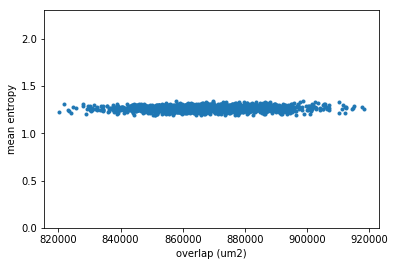

In [24]:
plt.scatter(np.array(overlaps), entropies, marker='.')
plt.xlabel("overlap (um2)")
plt.ylabel("mean entropy")
plt.ylim(0, np.log(number_of_bins))
plt.xlim()

In [25]:
random_orientation = np.random.uniform(-np.pi, np.pi, size=NI)

random_axons = spatial_layout.get_axonal_clouds(random_orientation)

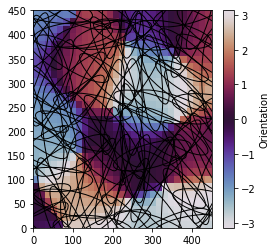

In [26]:
plot_neural_sheet(ex_positions, ex_tunings, random_axons)

##### Entropy

In [27]:
spatial_layout.get_mean_entropy(random_orientation, number_of_bins)

1.2484661113620952

In [28]:
np.log(number_of_bins)

2.302585092994046

##### Overlap

In [29]:
spatial_layout.get_overlap(random_orientation, ds)

886050.0

In [30]:
NI*random_axons[0].get_area()-sheet_size**2

582898.1633974483

#### Optimize entropy

In [31]:
res_entropy = differential_evolution(spatial_layout.get_negative_mean_entropy, [ (0, np.pi) for _ in range(NI)], maxiter = maxiter, popsize=popsize_multiplier, seed=3, disp=True, args=(number_of_bins,), workers=workers)


WARNING    /home/pfeiffer/Applications/miniconda2/envs/interneuron_polarity/lib/python3.7/site-packages/scipy/optimize/_differentialevolution.py:494: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  " updating='deferred'", UserWarning)
 [py.warnings]


differential_evolution step 1: f(x)= -1.3497
differential_evolution step 2: f(x)= -1.3497
differential_evolution step 3: f(x)= -1.35143
differential_evolution step 4: f(x)= -1.39029
differential_evolution step 5: f(x)= -1.39029


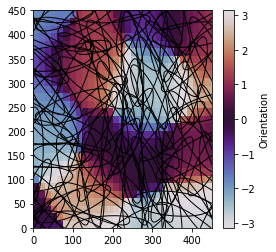

In [32]:
plot_neural_sheet(ex_positions, ex_tunings, spatial_layout.get_axonal_clouds(res_entropy.x))

In [33]:
spatial_layout.get_overlap(res_entropy.x, ds)

860400.0

#### Optimize overlap

In [34]:
res_overlap = differential_evolution(spatial_layout.get_overlap, [ (0, np.pi) for _ in range(NI)], maxiter = maxiter, popsize=popsize_multiplier, seed=3, disp=True, args=(ds,), workers=workers)


differential_evolution step 1: f(x)= 820575
differential_evolution step 2: f(x)= 820575
differential_evolution step 3: f(x)= 820575
differential_evolution step 4: f(x)= 806625
differential_evolution step 5: f(x)= 803700


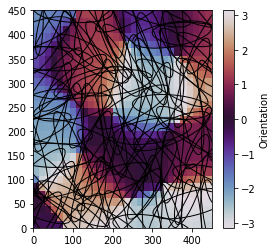

In [35]:
plot_neural_sheet(ex_positions, ex_tunings, spatial_layout.get_axonal_clouds(res_overlap.x))

In [36]:
spatial_layout.get_mean_entropy(res_overlap.x, number_of_bins)

1.297284101432205

### Ensure overlap avoidance via bounds

#### How much overlap do we see in the circular case?

In [37]:
from scripts.spatial_layout import get_overlap_matrix, get_entropies

In [38]:
circular_radius = np.sqrt(long_axis*short_axis)
circular_axons = [Pickle(pos[0], pos[1], circular_radius, circular_radius, 0) for pos in spatial_layout.in_positions]

circular_overlap = np.sum(get_overlap_matrix(circular_axons, sheet_size/100.0))

circular_entropy = np.mean(get_entropies(circular_axons, ex_positions, ex_tunings, entropy_bins=np.linspace(-np.pi, np.pi, number_of_bins+1)))

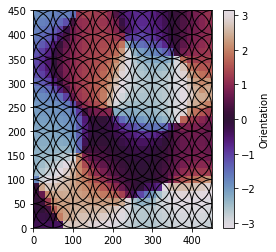

In [39]:
plot_neural_sheet(ex_positions, ex_tunings, circular_axons)

In [40]:
circular_overlap

783675.0

In [41]:
circular_entropy

1.1303718810016554

#### What is the entropy in our custom entropy maximisation?

Note that interneuron placement is slightly different

In [42]:
from scripts.interneuron_placement import create_interneuron_sheet_entropy_max_orientation

In [43]:
axons, max_mean_entropy = create_interneuron_sheet_entropy_max_orientation(ex_positions, ex_tunings, NI, long_axis, short_axis, sheet_size, sheet_size, trial_orientations=30, number_of_bins=number_of_bins)

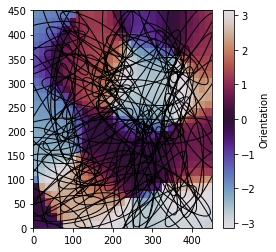

In [44]:
plot_neural_sheet(ex_positions, ex_tunings, axons)

In [45]:
max_entropy_orientations = np.array([axon.phi for axon in axons])

In [46]:
spatial_layout.get_overlap(max_entropy_orientations, ds)

937800.0

In [47]:
max_mean_entropy

1.6493477092942046

#### Define bound by circular overlap

In [48]:
from scipy.optimize import NonlinearConstraint

In [49]:
min_overlap = min(overlaps)

In [50]:
max_overlap = max(overlaps)

In [51]:
np.std(overlaps)

15772.414881288787

In [52]:
overlap_lim = np.mean(overlaps)-2*np.std(overlaps)

In [53]:
overlap_lim

835800.4202374225

In [54]:
overlap_lim/circular_overlap

1.0665140782051519

In [55]:
overlap_constraint = NonlinearConstraint(lambda orientation_array: spatial_layout.get_overlap(orientation_array, ds), lb=0, ub=overlap_lim)

In [56]:
res_overlap_constraint = differential_evolution(spatial_layout.get_negative_mean_entropy, [ (0, np.pi) for _ in range(NI)], maxiter = maxiter, popsize=popsize_multiplier, seed=3, disp=True, constraints=(overlap_constraint), polish=False, args=(number_of_bins,), workers=3)


differential_evolution step 1: f(x)= -1.28856
differential_evolution step 2: f(x)= -1.28856
differential_evolution step 3: f(x)= -1.29346
differential_evolution step 4: f(x)= -1.30258
differential_evolution step 5: f(x)= -1.30258


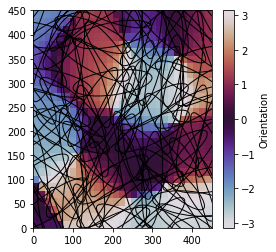

In [57]:
plot_neural_sheet(ex_positions, ex_tunings, spatial_layout.get_axonal_clouds(res_overlap_constraint.x))

In [58]:
spatial_layout.get_overlap(res_overlap_constraint.x, ds)

834975.0

In [59]:
spatial_layout.get_mean_entropy(res_overlap_constraint.x, number_of_bins)

1.3025825512429807

(0, 2.302585092994046)

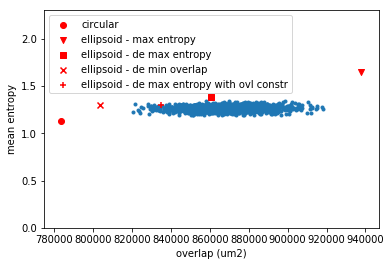

In [60]:
plt.scatter(np.array(overlaps), entropies, marker='.')
plt.scatter(circular_overlap, circular_entropy, color='red', marker='o', label="circular")
plt.scatter(spatial_layout.get_overlap(max_entropy_orientations, ds), max_mean_entropy, color='red', marker='v', label="ellipsoid - max entropy")
plt.scatter(spatial_layout.get_overlap(res_entropy.x, ds), spatial_layout.get_mean_entropy(res_entropy.x, number_of_bins), color='red', marker='s', label="ellipsoid - de max entropy")
plt.scatter(spatial_layout.get_overlap(res_overlap.x, ds), spatial_layout.get_mean_entropy(res_overlap.x, number_of_bins), color='red', marker='x', label="ellipsoid - de min overlap")
plt.scatter(spatial_layout.get_overlap(res_overlap_constraint.x, ds), spatial_layout.get_mean_entropy(res_overlap_constraint.x, number_of_bins), color='red', marker='+', label="ellipsoid - de max entropy with ovl constr")


plt.legend()


plt.xlabel("overlap (um2)")
plt.ylabel("mean entropy")
plt.ylim(0, np.log(number_of_bins))


# Observations

### Technical

* multiple workers fails because the overlap function cannot be pickled => closures cannot be pickled, but a class derived from object can be pickled if it is imported correctly https://stackoverflow.com/questions/1412787/picklingerror-cant-pickle-class-decimal-decimal-its-not-the-same-object
* how to do multiprocessing in a notebook https://stackoverflow.com/questions/48846085/python-multiprocessing-within-jupyter-notebook
* overlaps are also calculated for ellipsoids that reach out of the sheet
* overlap calculation grow quadratically with interneuron number -> very costly at the moment
* entropy calculation grows quadratically with excitatory neuron number and linearly with inteneuron number
* BUG in orientation map generation? always the same sheet size and neuron number?
* for constrained differential evolution, scipy >1.4  is required, to install this I had to fight with some user site problem, basically a higher priority package place, see https://github.com/conda/conda/issues/448
* diff evol in scipy 1.4. seems to be much slower than in scipy 1.2, unclear why?
* would be valuable to draw mean entropy and overlap for a large random sample

### Conceptual
* very frustrated system
* small progress, even for the single objective functions, unclear whether recombination or mutation induce any kind of directed search, could we instead just sample and get the best results



## Further ideas

* multi-objective optimization library [Platypus](https://platypus.readthedocs.io/en/latest/index.html) from this [blog](https://pablormier.github.io/2017/09/05/a-tutorial-on-differential-evolution-with-python/)
* one could also use entropy as a bound or overlap....
* different approach via secondary connectivity of excitatory neurons
